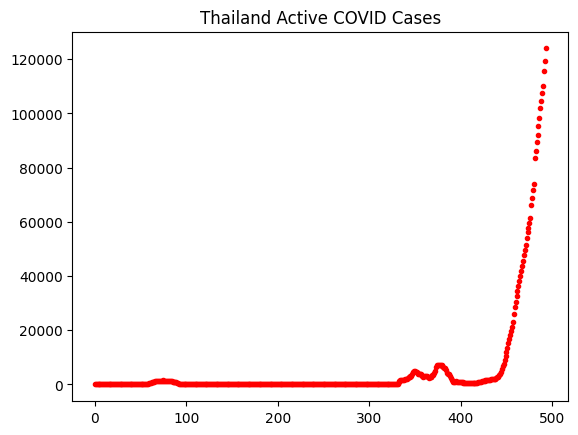

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv('/Users/creamy/Desktop/archive (1)/covid_19_data.csv')

thailand = df[df['Country/Region'] == 'Thailand'].copy() # Find Thailand data

thailand['Active'] = thailand['Confirmed'] - thailand['Deaths'] - thailand['Recovered'] # Compute the active cases


plt.plot(thailand['Active'].values, 'r.')
plt.title("Thailand Active COVID Cases")
plt.show()

** Find Beta and SSE


Rt = 1.6
Beta = 0.2


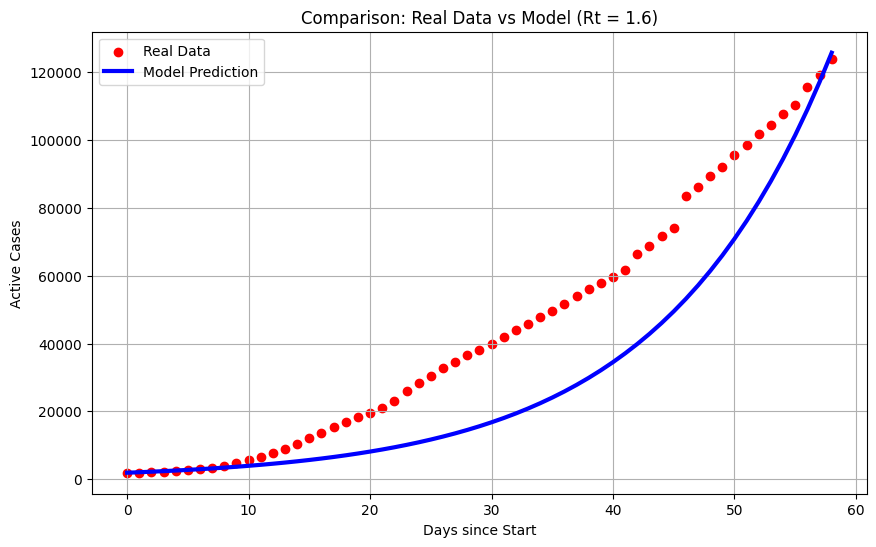

In [27]:
df = pd.read_csv('/Users/creamy/Desktop/archive (1)/covid_19_data.csv')
thailand = df[df['Country/Region'] == 'Thailand'].copy()
thailand['ObservationDate'] = pd.to_datetime(thailand['ObservationDate'])
start, end = '2021-04-01', '2021-09-01'
mask = (thailand['ObservationDate'] >= start) & (thailand['ObservationDate'] <= end)
my_data = thailand.loc[mask]
real_active = (my_data['Confirmed'] - my_data['Deaths'] - my_data['Recovered']).values
days = np.arange(len(real_active))

start, end = '2021-04-01', '2021-05-29'
mask = (thailand['ObservationDate'] >= start) & (thailand['ObservationDate'] <= end)
my_data = thailand.loc[mask]
real_active = (my_data['Confirmed'] - my_data['Deaths'] - my_data['Recovered']).values
days = np.arange(len(real_active))

N = 70000000  # Population in 2021
recovery_day = 8
gamma = 1 / recovery_day  
sick_covid = real_active[0]  # Find sick people start from Day 0
healthy_people = N - sick_people 


possible_betas = np.arange(0.10, 0.51, 0.01) # start from beta = 0.1 from Rt = 0.8(min), stop at beta = 0.51 from Rt = 5 (max), jump to 0.01

best_beta = 0 # Find the best beta from the dataset
lowest_error = float('inf')  # Find the least error by compare with each one but it never get reached to infinity
best_prediction = []  # Check the best prediction (Blue line)

for test_beta in possible_betas:
    
    H, C, R = healthy_people, sick_covid, 0
    current_prediction = [] # see for the next day

    for day in days: # Check for each days in the dataset
        current_prediction.append(C) #check for the new covid people
        
        # ODE Formulas
        new_sick      = (test_beta * H * C) / N
        new_recovered = gamma * C
        
        # Update for Tomorrow
        H = H - new_sick # check healthy people - covid people
        C = C + new_sick - new_recovered # people who already got covid + new covid people - recovered people
        R = R + new_recovered # people who already recovered + new recovered people

    # Compute SSE (The Error)
    total_error = 0 # set the error to be 0
    for i in range(len(days)): # loop the amount of days from the dataset
        real_val = real_active[i] # sick people start from day 0 (Red dot)
        pred_val = current_prediction[i] # check for the new covid people (Blue line)
        diff = real_val - pred_val # find the mistake between real data and prediction data
        total_error = total_error + (diff * diff) # square the mistake to make it positive , compute the total mistake 
    
    # SSE
    if total_error < lowest_error: # Find the least error
        lowest_error = total_error # update the lowest one
        best_beta = test_beta # save the best beta (value)
        best_prediction = current_prediction # save the best prediction graph (Blue line)

Rt = best_beta / gamma
simple_Rt = round(Rt, 2)       
simple_beta = round(best_beta, 2) 

print("Rt =", simple_Rt)
print("Beta =", simple_beta)

plt.figure(figsize=(10,6))
plt.scatter(days, real_active, color='red', label='Real Data')
plt.plot(days, best_prediction, color='blue', linewidth=3, label='Model Prediction')

plt.title("Comparison: Real Data vs Model (Rt = " + str(simple_Rt) + ")")
plt.xlabel("Days since Start")
plt.ylabel("Active Cases")
plt.legend()
plt.grid(True)
plt.show()


    

Hospitals will be full on: Day 31.3
Hospitals will be full on: 2021-05-02


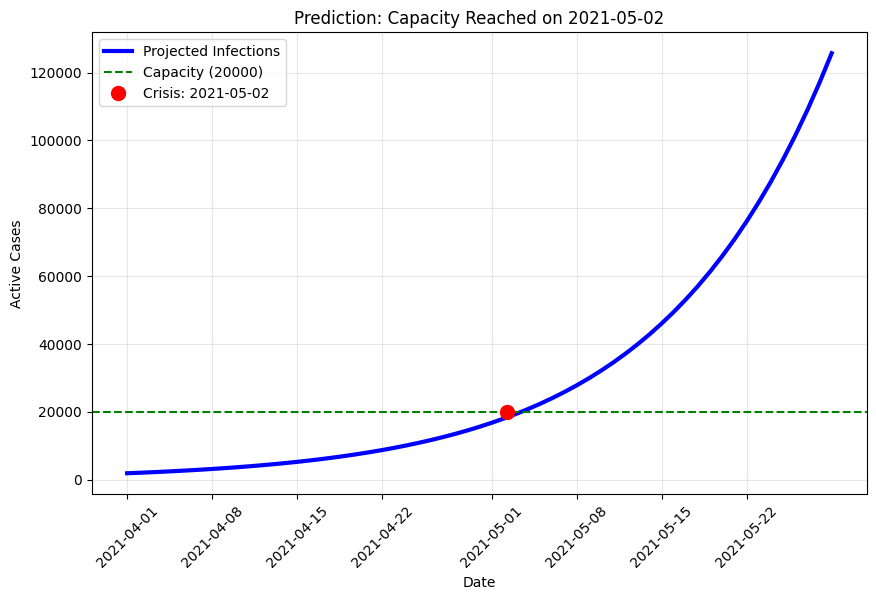

In [28]:
amount_hospital = 20000 

def infected_people(target_day): # target day = mid day : check the number of sick people on each day
    H, C, R = healthy_people, sick_covid, 0
    
    current_day = 0
    dt = 0.1 # to check for the accurate day

    while current_day < target_day: # check until the target day
        new_sick      = (best_beta * H * C) / N * dt # multiply dt because it goes by 0.1 days
        new_recovered = gamma * C * dt
        
        H = H - new_sick
        C = C + new_sick - new_recovered
        R = R + new_recovered
        
        current_day += dt # calculate the next 0.1 days
        
    return C

# Bisection
low_day = 0.0 # The first April (Floor)
high_day = 150.0 # September (Ceiling)
tolerance = 0.01 # Get the accurate answer in term of 0.01
crisis_day = -1 # Have not find the answer yet: positive number (day that it will be fulled)

while (high_day - low_day) > tolerance: # Loop until withinn 0.01
    
    mid_day = (low_day + high_day) / 2 # find the middle day
    
    sick_people = infected_people(mid_day) # sick people from the day above
    
    if sick_people > amount_hospital: 
        high_day = mid_day # Many sick people
    else:
        low_day = mid_day # Not full yet might happen later

crisis_day = (low_day + high_day) / 2 # calculate the average between the low and high day that is very small differnce

simple_day = round(crisis_day, 2)
print("Hospitals will be full on: Day", simple_day)

date_list = pd.date_range(start='2021-04-01', periods=len(days))

from datetime import timedelta
crisis_date = pd.to_datetime('2021-04-01') + timedelta(days=crisis_day)

date_list = pd.date_range(start='2021-04-01', periods=len(days))

from datetime import timedelta
crisis_date = pd.to_datetime('2021-04-01') + timedelta(days=crisis_day)

date_text = str(crisis_date.date()) 

print("Hospitals will be full on:", date_text)

plt.figure(figsize=(10,6))

plt.plot(date_list, best_prediction, color='blue', linewidth=3, label='Projected Infections')

plt.axhline(y=amount_hospital, color='green', linestyle='--', label="Capacity (" + str(amount_hospital) + ")")

plt.plot(crisis_date, amount_hospital, 'ro', markersize=10, label="Crisis: " + date_text)

plt.title("Prediction: Capacity Reached on " + date_text)
plt.xlabel("Date")
plt.ylabel("Active Cases")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45) 
plt.show()